In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer
from lowEBMs.Packages.RK4 import rk4alg, controlrun
from lowEBMs.Packages.ModelEquation import model_equation
from lowEBMs.Packages.Variables import Vars,reset, trackerreset, datareset
from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs import update_plotstyle
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1
time_sec_year=60*60*24*365
def moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period,len(signal)):
        buffer.append(signal[i-period:i].mean())
    return buffer

In [2]:
time_HADCM3_str=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[0],delimiter=',',skip_header=1,dtype='str',unpack=True,encoding='ISO-8859-1')
time_HADCM3=np.zeros(len(time_HADCM3_str))
for i in range(len(time_HADCM3_str)):
    if time_HADCM3_str[i][-4]=='.':
        year=float(time_HADCM3_str[i][-3:])
    if time_HADCM3_str[i][-5]=='.':
        year=float(time_HADCM3_str[i][-4:])
    if time_HADCM3_str[i][4]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    if time_HADCM3_str[i][5]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    day=float(time_HADCM3_str[i][:2])/365
    time_HADCM3[i]=year+month+day
GMT_HADCM3=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[17],delimiter=',',skip_header=1,unpack=True,encoding='ISO-8859-1')
order=np.argsort(time_HADCM3)
GMT_HADCM3_smoothed=moving_average(GMT_HADCM3[order],12)

In [3]:
Year_volc, CWL_GMT,  EVA_GMT, CWLcorr_GMT=np.genfromtxt('Data/Volc_800_2000.txt',skip_header=1,unpack=True)
#Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
#np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)

In [4]:
Year_volc_1800_1850=Year_volc[int(1000*365/4):int(1040*365/4)]
Year_volc_1808_1858=Year_volc[int(1008*365/4):int(1048*365/4)]
EVA_GMT_1800_1850=EVA_GMT[int(1000*365/4):int(1040*365/4)]
EVA_GMT_1808_1858=EVA_GMT[int(1008*365/4):int(1048*365/4)]

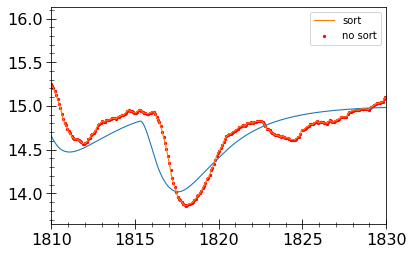

In [5]:
#print(time_HADCM3)
#print(GMT_HADCM3)
plt.plot(Year_volc,CWL_GMT+15)
plt.scatter(time_HADCM3,moving_average(GMT_HADCM3,12),s=5,c='r',label='no sort')
plt.plot(time_HADCM3[order],moving_average(GMT_HADCM3[order],12),label='sort')
#plt.plot(time_HADCM3,moving_average(GMT_HADCM3,12),label='sort')
plt.xlim(1810,1830)
plt.legend()
#plt.savefig('HADCM3-data.png',format='PNG')

In [5]:
def coremodule(config,P0,P_pert,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))    
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    #for i in range(maxlength):
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert[0]/P0[0]

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig)
            dataout[i]=data
        if targetmode=='Coupled':
            target_ZMT=target[0]
            target_GMT=target[1]
            F_ZMT=target_comparison(data_ZMT,'ZMT',target,targetfunction,grid,num_paras,elevation)
            F_GMT=target_comparison(data_GMT,'ZMT',target,targetfunction,grid,num_paras,elevation)
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,grid,num_paras,elevation)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,grid,num_paras,elevation):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(data)):
                data[i]=data[i]+elevation
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig):
    
    elif targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=False)

        controlconfig=add_parameters(controlconfig,P,labels)
        #Vars.T,Vars.T_global=ZMT,GMT
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    
    if control==True:
        Vars.T,Vars.T_global=np.array([ZMT]*int(len(P)*2+1)),np.array([GMT]*int(len(P)*2+1))
    else:
        Vars.T,Vars.T_global=ZMT,GMT
        
    data=rk4alg(model_equation,config['eqparam'],config['funccomp'],progressbar=True)
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        data_out=data[1][-1]
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        data_out=[data_CTRL[1][-1],np.transpose(data[2][:-1]-data[2][0])]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [21]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b']]
labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P0=np.array([70*4.2e6,230,2.5])
P0=np.array([70*4.2e6,0.5,1.9e-15,1.165,1.165,1.165])
Pmin=np.array([1*4.2e6,0.4,1e-15,0.9,0.9,0.9])
Pmax=np.array([1000*4.2e6,0.55,9e-15,1.3,1.3,1.3])
P_pert=(Pmax-Pmin)/10000
#Pmin=np.array([20*4.2e6,190,1.7])
#Pmax=np.array([120*4.2e6,250,3.3])
#P_pert=(Pmax-Pmin)/100
precision=1e-5
maxlength=int(10)
targetmode='GMT'
target=EVA_GMT_1808_1858
targetfunction='LeastSquare'
num_params=6
gamma0=1e-7
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
        
config_base=importer('Dev_Data/Optimization/Volcanic_Sellers.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,elevation,precision,num_params,gamma0,control,config_CTRL)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[6132.93262311 6118.5067464  6147.38300824 6073.68224443 6192.26996023
 5663.46055388 6639.16182973 6132.22782752 6133.63684312 6132.79372249
 6133.07089645 6130.26327026 6135.60637413]
1e-07
[3.55457474e+08 5.00934813e-01 4.33084291e-15 1.16502981e+00
 1.16500586e+00 1.16511302e+00]
Iteration no.1


[11.76478614 11.7977597  11.73197415 11.04663482 12.52233212 11.63655106
 11.89428818 11.76305274 11.76653    11.76411002 11.76546337 11.75386131
 11.77571628]
1.0002633692994735e-07
[3.55317425e+08 5.00946449e-01 4.33148520e-15 1.16502988e+00
 1.16500589e+00 1.16511349e+00]
Iteration no.2


[11.72626344 11.75918251 11.69349969 11.00934708 12.48243864 11.598369
 11.85546427 11.72452669 11.72799737 11.72558251 11.72693872 11.71535007
 11.73717565]
4.62547396384212e-05
[2.90656528e+08 5.06317646e-01 4.62775702e-15 1.16506384e+00
 1.16501916e+00 1.16532704e+00]
Iteration no.3


[4.13697019 4.13362332 4.14068494 3.67195827 4.63982987 4.08615564
 4.18826727 4.13623735 4.13770312 4.13668047 4.13725992 4.13240399
 4.14156049]
7.522339846810474e-05
[3.01962059e+08 5.12056904e-01 4.81912452e-15 1.16508716e+00
 1.16502838e+00 1.16547274e+00]
Iteration no.4


[3.75953036 3.76532563 3.75403923 3.31479474 4.2425291  3.7247731
 3.7945371  3.75889784 3.76016296 3.75927496 3.75978577 3.75548128
 3.76358254]
0.0001800951705616265
[2.58701604e+08 5.25227662e-01 5.13214550e-15 1.16513536e+00
 1.16504784e+00 1.16578136e+00]
Iteration no.5


[4.57235787 4.53653556 4.60871034 4.15793412 5.02766274 4.55513293
 4.58966453 4.5718877  4.5728281  4.57216291 4.57255284 4.56926928
 4.57544881]
5.897844371306057e-05
[3.49298338e+08 5.29271206e-01 5.18288544e-15 1.16514709e+00
 1.16505271e+00 1.16585846e+00]
Iteration no.6


[5.46129854 5.49273226 5.43003102 5.03521577 5.92735902 5.44590124
 5.47675897 5.46079879 5.46179835 5.46109212 5.46150498 5.45801324
 5.46458601]
3.10191808387152e-05
[3.07904073e+08 5.31452680e-01 5.20673247e-15 1.16515365e+00
 1.16505542e+00 1.16590158e+00]
Iteration no.7


[3.36055567 3.37045629 3.35093613 2.93367492 3.82862045 3.34622482
 3.3749435  3.3600745  3.36103689 3.36035768 3.36075366 3.35739793
 3.36371558]
4.496566237035517e-05
[2.89223159e+08 5.34624895e-01 5.23890502e-15 1.16516280e+00
 1.16505918e+00 1.16596167e+00]
Iteration no.8


[3.26566075 3.26143973 3.27023855 2.83434918 3.73916087 3.25260906
 3.27876117 3.26518922 3.26613233 3.2654677  3.26585381 3.26257145
 3.2687522 ]
2.711968487964828e-05
[2.94301743e+08 5.36559213e-01 5.25657480e-15 1.16516821e+00
 1.16506140e+00 1.16599713e+00]
Iteration no.9


[1.00000000e-07 1.00026337e-07 4.62547396e-05 7.52233985e-05
 1.80095171e-04 5.89784437e-05 3.10191808e-05 4.49656624e-05
 2.71196849e-05 7.52069916e-07]


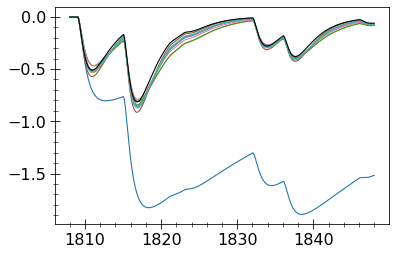

In [22]:
for i in range(10):
    plt.plot(Year_volc_1808_1858,data[i,0],label=i)
#plt.plot(Year_volc_1808_1858,data[1,1])
#plt.plot(Year_volc_1808_1858,data[1,2])
#plt.plot(Year_volc_1808_1858,data[1,3])
#plt.plot(Year_volc_1808_1858,data[1,4])
plt.plot(Year_volc_1808_1858,EVA_GMT_1808_1858,c='k')
#plt.legend()
#plt.xlim(1808,1858)
print(gamma)

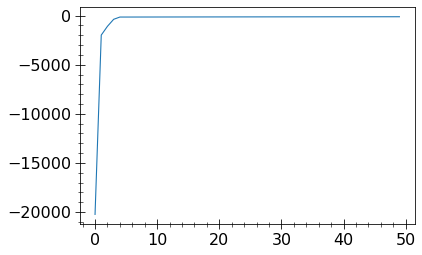

In [13]:
plt.plot(np.arange(50),dF[:,0])

In [18]:
print(gamma)
print(F)
print(dF)
print(P)

[1.00000000e-07 1.04612403e-07 2.97075138e-06 4.02580534e-06
 1.49940221e-05 6.34839056e-06 6.75989985e-06 6.95966764e-06
 7.15319242e-06 7.33837198e-06]
[[6132.93262311 6131.50347094 6134.38248311 6054.02001132 6212.34085157
  6011.55978044 6256.12383047 6132.22782752 6133.63684312 6132.79372249
  6133.07089645 6130.26327026 6135.60637413]
 [ 194.04217593  194.03072371  194.05363385  187.56341085  200.65345179
   190.19187825  197.94035352  194.01506563  194.06928886  194.03338032
   194.05097181  193.89555674  194.18887108]
 [ 187.19452502  187.18355695  187.20549871  180.80588812  193.71695559
   183.53294471  190.9010645   187.16817187  187.22088074  187.18597383
   187.20307647  187.05170042  187.3374244 ]
 [  27.70841592   27.70732828   27.7095074    25.51474996   30.01994128
    27.32338782   28.09705102   27.70537131   27.71146078   27.70730518
    27.70952669   27.68951878   27.72732248]
 [  16.64433868   16.64373334   16.64494771   14.94159051   18.46930358
    16.44706135   

In [20]:
print(2.95194112e+08/4.2e6)

70.28431238095239
